In [1]:
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as smf #R-like model specification
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns #refined plotting
import statsmodels.formula.api as smf  # R-like model specification
from pandas import DataFrame
from pandas import TimeGrouper
#pd.set_option('display.max_columns', None) # tweak Pandas so that I can see all columns when printing

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ImportError: ignored

In [ ]:
# load first dataset
from google.colab import files
uploaded = files.upload()

Saving ZillowData.csv to ZillowData (2).csv


In [ ]:
#Encoding had to be changed from the default utf=8 in order to read in the csv file
zillow = pd.read_csv("ZillowData.csv", encoding = "ISO-8859-1")
#Want to remove any NaN values to make sure they don't negatively impact or skew analysis.
zillow = zillow.dropna()
#subet only AR metro areas
tsmetro = (zillow.loc[zillow['Metro'].isin(['Hot Springs','Little Rock-North Little Rock-Conway','Fayetteville-Springdale-Rogers', 'Searcy'])])
tsmetro.columns
#Group by metro averages
tsmetro = tsmetro.groupby(['Metro']).mean().reset_index() #Thanks to Stack Overflow for the reset_index trick
tsmetro = tsmetro.drop(['RegionID', 'RegionName', 'SizeRank'], axis=1)
tsmetro.columns


Index(['Metro', '1996-04', '1996-05', '1996-06', '1996-07', '1996-08',
       '1996-09', '1996-10', '1996-11', '1996-12',
       ...
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06'],
      dtype='object', length=280)

In [ ]:
#Create a new list using all the columns in tsmetro minus the Metro column
date_columns = tsmetro.iloc[:,1:279].columns.tolist()
#Convert to int format
tsmetro[date_columns] = tsmetro[date_columns].astype(int)
tsmetro


,Metro,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,...,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06
0,Fayetteville-Springdale-Rogers,78577,78659,78686,78695,78740,78827,78986,79195,79486,79900,80431,80977,81481,81854,82081,82172,82113,81981,81809,81554,81277,81081,80936,80772,80545,80300,80031,79795,79609,79500,79527,79609,79754,80050,80490,80968,81454,81890,82259,...,135795,136927,138095,139063,140154,141209,142172,143313,144468,145372,146159,147004,148081,149345,150686,152050,153000,153554,154222,154736,154954,155195,156263,158113,160159,161640,162836,163713,164695,165777,167236,168927,170636,171977,172836,173472,174086,174513,175040,175540.909091
1,Hot Springs,71425,71525,71650,71725,71825,71875,71950,71975,72050,72150,72300,72400,72550,72825,73175,73550,74000,74475,75000,75475,76050,76675,77275,77750,78250,78700,79125,79475,79775,80050,80300,80500,80725,80950,81175,81325,81475,81675,81850,...,132550,132600,132775,132975,133050,133375,134350,135525,136075,137150,138875,140200,139950,139000,138725,139775,140600,140675,140875,141375,141675,141200,140475,140600,141625,141975,142125,142875,144100,145150,146100,146800,147200,147825,148575,148650,148600,149000,149075,148725.000000
2,Little Rock-North Little Rock-Conway,83266,83476,83653,83816,83946,84080,84240,84440,84750,85206,85733,86260,86823,87356,87866,88336,88756,89140,89470,89733,90016,90343,90670,90893,91076,91230,91370,91520,91680,91873,92106,92330,92620,92990,93410,93733,94010,94220,94373,...,149423,149803,150163,150476,150840,151296,151853,152540,153326,154340,155186,155850,156766,157806,158553,159256,159846,160200,160386,160220,159730,159453,159840,160590,161110,161416,162100,162866,163390,163750,164316,164980,165793,166450,166880,167080,167096,166993,166810,166656.666667
3,Searcy,60640,60800,60940,61100,61240,61380,61520,61700,61960,62180,62440,62680,62960,63220,63500,63780,64080,64340,64580,64880,65220,65580,65980,66360,66820,67200,67700,68120,68540,68920,69220,69560,69860,70160,70440,70660,70880,71080,71300,...,95220,95520,96000,96880,97780,98680,99140,99200,99020,99180,99980,100540,100420,100080,100020,99740,99880,100740,101580,101480,101320,101540,102400,103660,104560,104780,104960,105120,105140,104860,105360,106980,108960,110080,110680,111080,111620,111680,111460,111380.000000


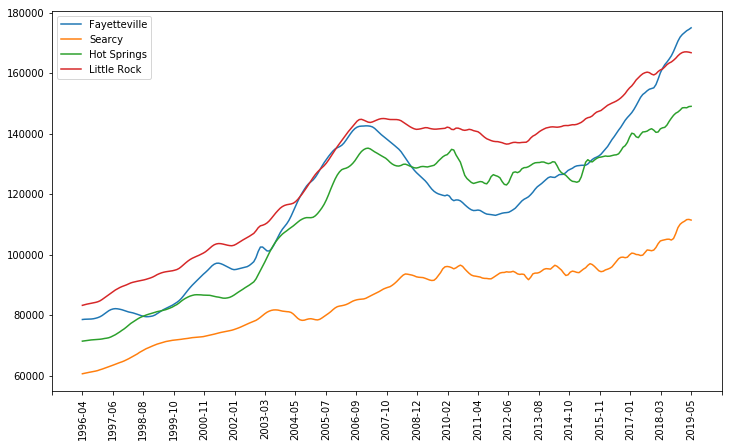

In [ ]:
#Create df for each metro area for time series plot
hotsprings = tsmetro.loc[(tsmetro['Metro'] == 'Hot Springs')]
littlerock = tsmetro.loc[(tsmetro['Metro'] == 'Little Rock-North Little Rock-Conway')]
fayetteville = tsmetro.loc[(tsmetro['Metro'] == 'Fayetteville-Springdale-Rogers')]
searcy = tsmetro.loc[(tsmetro['Metro'] == 'Searcy')]
#Create initial time series plots
fig, tsplot = plt.subplots(figsize=(12, 7))
tsplot.plot(fayetteville[date_columns].mean(), linestyle='solid')
tsplot.plot(searcy[date_columns].mean(), linestyle='solid')
tsplot.plot(hotsprings[date_columns].mean(), linestyle='solid')
tsplot.plot(littlerock[date_columns].mean(), linestyle='solid')
# space out the tick marks so they are not overlapping
xmin, xmax = tsplot.get_xlim()
tsplot.set_xticks(np.round(np.linspace(xmin, xmax, 23), 2))
# rotate ticks + show legend
plt.xticks(rotation=90)
plt.gca().legend(('Fayetteville', 'Searcy', 'Hot Springs', 'Little Rock'))
#Show plot
plt.show()


In [ ]:
#Predict average housing value for 2018 using Prophet
#Install prophet for use
!pip install fbprophet
from fbprophet import Prophet
#Import timeit
import timeit


In [ ]:

#Melt df so that it can be used properly in Prophet
zillow_prophet = pd.melt(zillow, id_vars=["RegionID", "RegionName", "City", "State", "Metro", "CountyName", "SizeRank"], var_name = "YearMonth", value_name = "Value")
#Check df to make sure everything is good
#print(zillow_prophet.shape)
#print(zillow_prophet.dtypes)
#Change YearMonth from object to DateTime format
zillow_prophet['YearMonth'] = zillow_prophet['YearMonth'].astype('datetime64')
#print(zillow_prophet.dtypes)
#Remove unncessary columns
zillow_prophet = zillow_prophet[['RegionName','State','YearMonth','Value']]
#zillow_prophet.head(10)
#Rename YearMonth and Value to match Prophet standards
zillow_prophet = zillow_prophet.rename(index=str, columns={"YearMonth": "ds", "Value": "y"})
zillow_prophet.head(10)


,RegionName,State,ds,y
0,60657,IL,1996-04-01,337200.0
1,77494,TX,1996-04-01,210400.0
2,60614,IL,1996-04-01,502900.0
3,77449,TX,1996-04-01,95400.0
4,79936,TX,1996-04-01,77300.0
5,77084,TX,1996-04-01,95000.0
6,10467,NY,1996-04-01,151900.0
7,11226,NY,1996-04-01,161800.0
8,60640,IL,1996-04-01,218500.0
9,94109,CA,1996-04-01,767700.0


In [ ]:
#Subset df to cover my zip code as test
zip_home = zillow_prophet.loc[zillow_prophet['RegionName'] == 93311]
zip_home.head(10)
#Model with all values
#Set the uncertainty interval to 95% (the Prophet default is 80%)
zip_model = Prophet(interval_width=0.95)
zip_model.fit(zip_home)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future_dates = zip_model.make_future_dataframe(periods=12, freq='M')
future_dates.tail()

,ds
286,2020-01-31
287,2020-02-29
288,2020-03-31
289,2020-04-30
290,2020-05-31


In [ ]:
# MODEL
test_forecast = zip_model.predict(future_dates)
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
286,2020-01-31,287668.090199,271768.651036,302865.236448
287,2020-02-29,295585.059835,275399.482032,312277.075347
288,2020-03-31,295227.958787,271378.865277,318107.104589
289,2020-04-30,295008.853543,268705.428719,321165.877461
290,2020-05-31,295331.949112,266314.239956,324474.048891


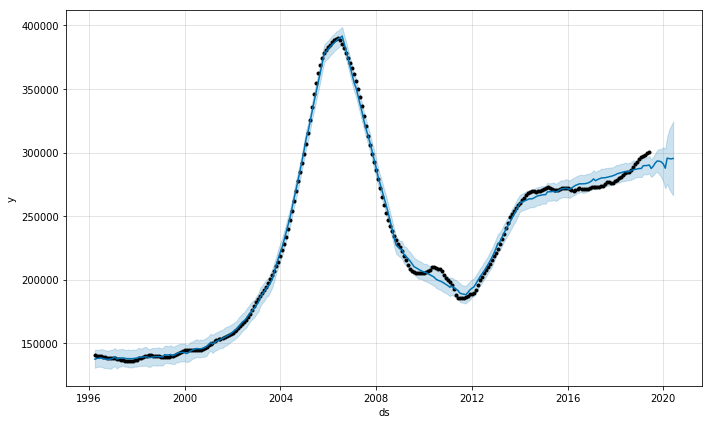

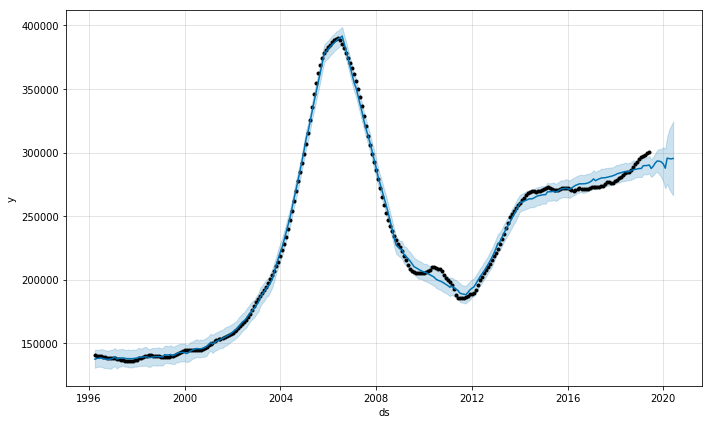

In [ ]:
#Visualize
zip_model.plot(test_forecast, uncertainty=True)

In [ ]:
#Generate list of zip codes for prophet
zip=[]
zip = list(zillow['RegionName'].unique())
print(zip)

[60657, 77494, 60614, 77449, 79936, 77084, 10467, 11226, 60640, 94109, 78660, 37013, 32162, 11235, 11375, 60647, 90250, 37211, 77573, 60618, 78130, 77584, 10128, 28269, 20002, 78613, 78572, 30349, 79912, 94565, 90046, 77433, 75052, 20009, 37042, 73099, 77429, 10462, 77479, 60613, 63376, 30044, 77036, 10463, 28277, 30043, 11212, 11230, 60625, 78245, 11209, 60629, 30096, 7030, 60610, 11221, 78704, 75287, 85032, 77077, 33160, 23464, 21234, 30024, 75243, 98052, 11214, 78521, 8701, 77379, 94501, 78666, 33411, 11229, 78745, 23462, 28027, 94110, 33025, 75067, 90034, 33139, 44107, 48197, 2169, 11377, 66062, 34787, 44035, 95630, 90044, 90805, 80134, 90650, 85710, 92683, 10314, 11211, 11234, 85281, 11355, 30281, 85225, 11215, 37075, 94558, 90026, 87114, 32210, 43081, 91910, 6010, 17603, 78240, 89108, 93722, 87111, 85308, 79938, 76063, 77459, 48180, 94533, 33908, 91709, 75056, 76028, 78577, 44060, 30040, 33024, 98012, 95608, 14850, 85364, 43123, 15601, 33647, 27587, 80013, 11385, 90066, 92677, 20

In [ ]:
#Model for all CA zipcodes
zip_ca = zillow_prophet.loc[zillow_prophet['State'] == 'CA']
zip_ca.head(10)
zip_ca = zip_ca[['RegionName', 'ds', 'y']]
zip_ca['IsHoliday'] = False
print(zip_ca.head())

    RegionName         ds         y  IsHoliday
9        94109 1996-04-01  767700.0      False
16       90250 1996-04-01  151500.0      False
29       94565 1996-04-01  133700.0      False
30       90046 1996-04-01  338300.0      False
70       94501 1996-04-01  221900.0      False


In [ ]:
#Create function to clean/rename selected dataframe
#Once cleaned, apply Prophet for 12 montly periods in the future to generate average forecasted value
#Export results as a csv file for analysis
predictions = []

for myzip in zip:
  zipdf = zip_ca[zip_ca['RegionName']==myzip]
  zipdf = zipdf.dropna(axis=0, how='all')
  zipdf = zipdf.rename(index=str, columns={"Value": "y", "YearMonth": "ds"})
  zip_model = Prophet(interval_width=0.95)
  try:
    zip_model.fit(zipdf)
    future_dates = zip_model.make_future_dataframe(periods=12, freq='M')
    forecast = zip_model.predict(future_dates)

    my_y = zipdf.iloc[0]['y']
    y_hat = forecast.iloc[-1]['yhat']  

    pred = {}
    pred['zip'] = myzip
    pred['y'] = my_y
    pred['yhat'] = y_hat
    pred['PctChange'] = (y_hat-my_y)/my_y
    pred['Delta'] = y_hat - my_y

    predictions.append(pred)
    print(pred)
  except:
    print("error")
    

df_predictions = pd.DataFrame.from_dict(predictions)
df_predictions.to_csv("df_predictions.csv")



In [ ]:
#Run Prohpet again for just the three zip codes to see forecasted value by month instead of yearly average
zip_1 = zillow_prophet.loc[zillow_prophet['RegionName'] == 90291]
zip_1 = zip_1[['RegionName','ds','y']]
zip_2 = zillow_prophet.loc[zillow_prophet['RegionName'] == 90038]
zip_2 = zip_2[['RegionName','ds','y']]
zip_3 = zillow_prophet.loc[zillow_prophet['RegionName'] == 94110]
zip_3 = zip_3[['RegionName','ds','y']]
#Set the uncertainty interval to 95% (the Prophet default is 80%)
zip_1_model = Prophet(interval_width=0.95)
zip_1_model.fit(zip_1)
zip_2_model = Prophet(interval_width=0.95)
zip_2_model.fit(zip_2)
zip_3_model = Prophet(interval_width=0.95)
zip_3_model.fit(zip_3)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
#Forecast
zip_forecast_1 = zip_1_model.predict(future_dates)
zip_forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
zip_forecast_2 = zip_2_model.predict(future_dates)
zip_forecast_2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
zip_forecast_3 = zip_3_model.predict(future_dates)
zip_forecast_3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
286,2020-01-31,1.746880e+06,1.690352e+06,1.804800e+06
287,2020-02-29,1.745405e+06,1.682059e+06,1.803409e+06
288,2020-03-31,1.751273e+06,1.689037e+06,1.815837e+06
289,2020-04-30,1.758146e+06,1.692517e+06,1.819650e+06
290,2020-05-31,1.761656e+06,1.693913e+06,1.831528e+06


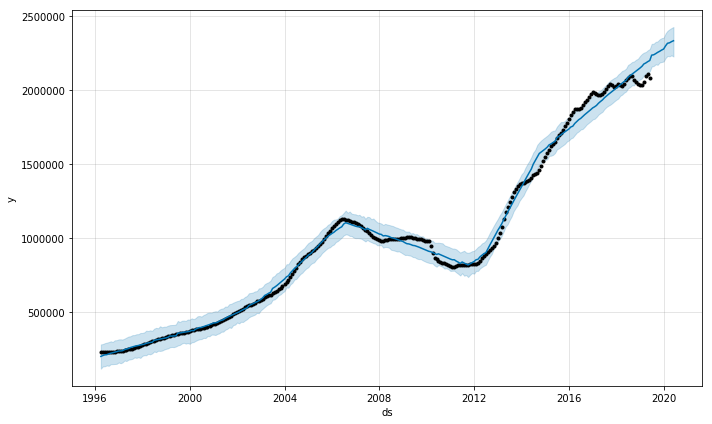

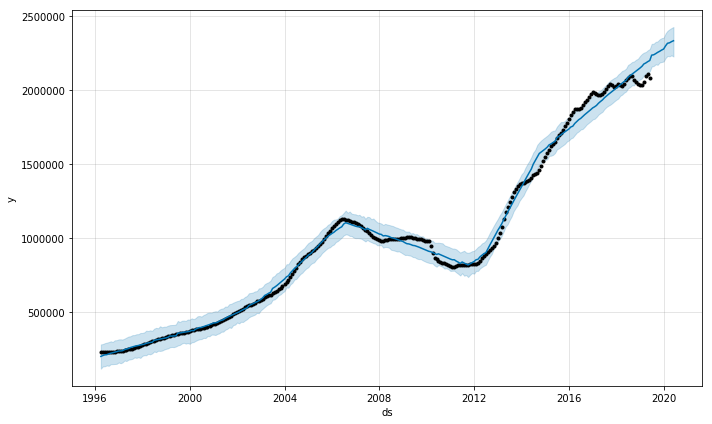

In [ ]:
#Visualize zip codes
zip_1_model.plot(zip_forecast_1, uncertainty=True)


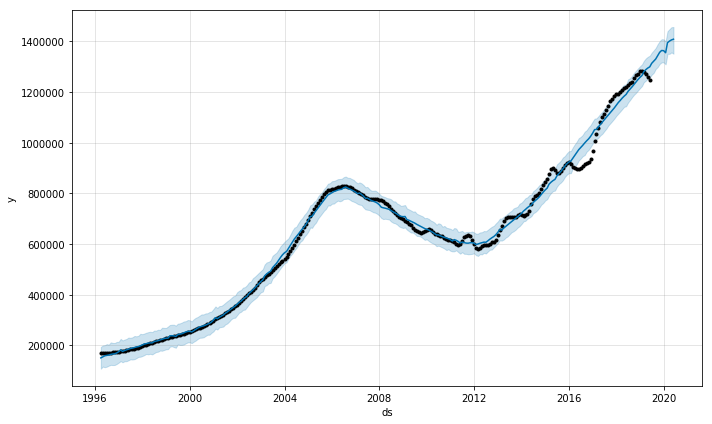

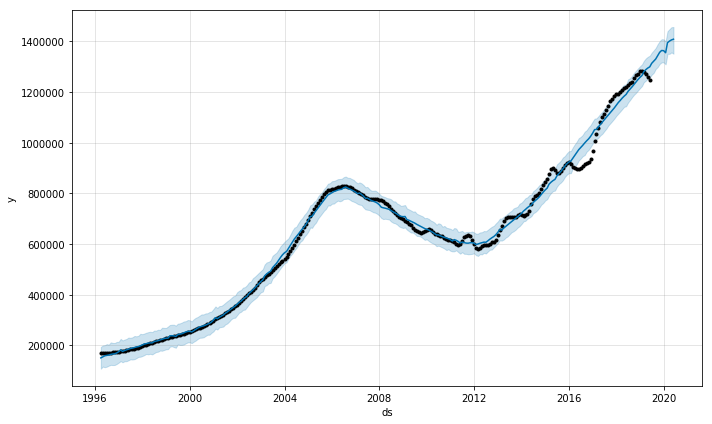

In [ ]:
zip_2_model.plot(zip_forecast_2, uncertainty=True)


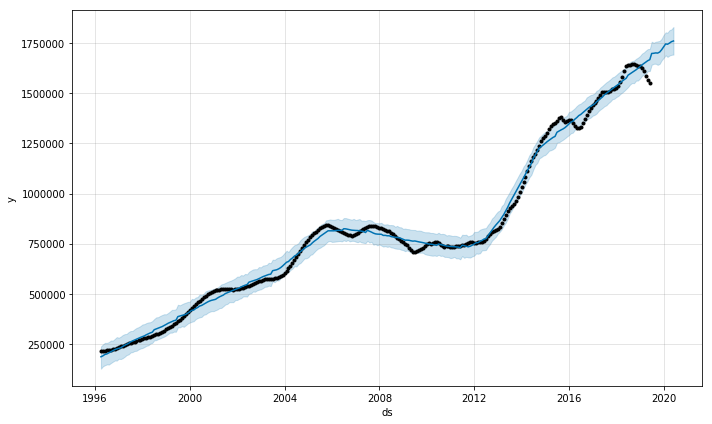

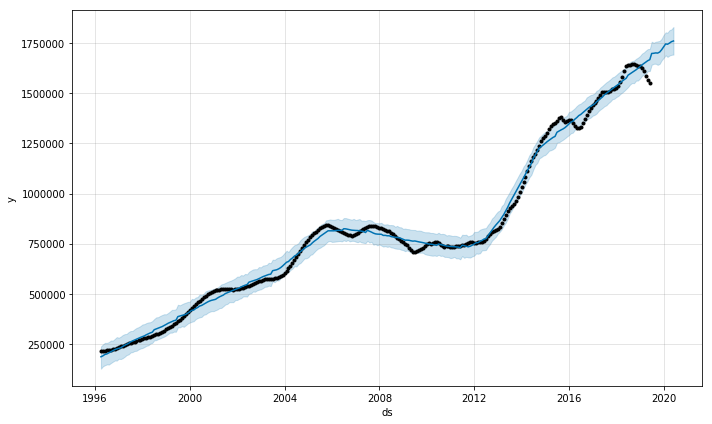

In [ ]:
zip_3_model.plot(zip_forecast_3, uncertainty=True)

In [ ]:
#Just for fun, using a friend's zip code to predict out to 2020
zip_fun = zillow_prophet.loc[zillow_prophet['RegionName'] == 95814]
zip_fun = zip_fun[['RegionName','ds','y']]
zip_fun_model = Prophet(interval_width=0.95)
zip_fun_model.fit(zip_fun)
zip_fun_forecast= zip_fun_model.predict(future_dates)
zip_fun_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



ValueError: ignored